CELDA 1: Importación de Librerías

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score

# Configuración visual
sns.set_style("whitegrid")
%matplotlib inline

CELDA 2: Carga de Datos y Configuración


In [14]:
# Rutas y Configuración
CARPETA_MODELO = '../../models/gsitalta'
TARGET = 'gsitalta_agrupada'

# Columnas a excluir (Variables "del futuro" o targets alternativos)
COLS_EXCLUIR = ['gsitalta', 'gsitalta_agrupada', 'ds_estancia', 'ds_pre_oper', 'ds_post_oper']

# Carga
df = pd.read_csv('/home/ubuntu/STG-fractura_cadera/2026/data_preprocessed/data_preprocessed_2018-2026/DATOS_PREPROCESADOS.csv')
print(f"Datos cargados: {df.shape[0]} pacientes, {df.shape[1]} columnas")

Datos cargados: 854 pacientes, 63 columnas


CELDA 3: Análisis del Desbalanceo (Crucial)

Distribución de la Variable Objetivo:
gsitalta_agrupada
0    806
1     48
Name: count, dtype: int64

En porcentajes:
gsitalta_agrupada
0    94.379391
1     5.620609
Name: proportion, dtype: float64


/tmp/ipykernel_33109/1740367020.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=TARGET, data=df, palette='viridis')


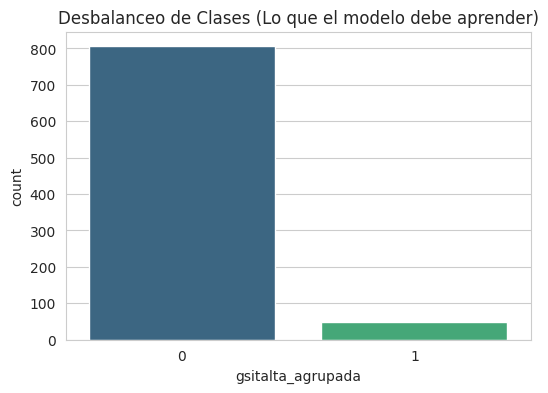

⚠️ NOTA: La clase minoritaria es solo el 5.62% de los datos.


In [15]:
# Verificamos cuántos casos hay de cada tipo
conteo = df[TARGET].value_counts()
porcentajes = df[TARGET].value_counts(normalize=True) * 100

print("Distribución de la Variable Objetivo:")
print(conteo)
print("\nEn porcentajes:")
print(porcentajes)

# Gráfico
plt.figure(figsize=(6, 4))
sns.countplot(x=TARGET, data=df, palette='viridis')
plt.title('Desbalanceo de Clases (Lo que el modelo debe aprender)')
plt.show()

print(f"⚠️ NOTA: La clase minoritaria es solo el {porcentajes.min():.2f}% de los datos.")

CELDA 4: Preprocesamiento (Limpieza y Escalado)

In [16]:
# 1. Separar X e y
X = df.drop(columns=COLS_EXCLUIR, errors='ignore')
y = df[TARGET]

# Guardamos el nombre de las columnas para el futuro
columnas_finales = X.columns.tolist()

# 2. Imputación (Rellenar nulos con la mediana)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# 3. Escalado (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 4. Codificar el Target (Texto -> Números 0, 1...)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
nombres_clases = le.classes_

print("✅ Preprocesamiento completado.")
print(f"Clases detectadas: {nombres_clases}")

✅ Preprocesamiento completado.
Clases detectadas: [0 1]


CELDA 5: División Train/Test y OVERSAMPLING (La Estrategia Clave)

In [17]:
# 1. División normal (80% Train, 20% Test)
# Usamos stratify para asegurar que haya al menos algún caso raro en el Test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Dimensiones Originales Train: {X_train.shape}")

# --- ESTRATEGIA DE OVERSAMPLING MANUAL ---
# Solo aplicamos esto al conjunto de ENTRENAMIENTO. El Test se deja real.

# Reconstruimos un DF temporal para facilitar el copiado
df_train = pd.DataFrame(X_train) # Las columnas ahora son 0, 1, 2... no importa
df_train['target'] = y_train

# Separamos las clases
clase_mayoritaria = df_train[df_train.target == 0]
clase_minoritaria = df_train[df_train.target == 1]

# Multiplicamos la clase minoritaria (Clonar pacientes raros)
clase_minoritaria_upsampled = clase_minoritaria.sample(
    n=len(clase_mayoritaria), # Igualamos a la mayoría
    replace=True, 
    random_state=42
)

# Combinamos de nuevo
df_train_balanced = pd.concat([clase_mayoritaria, clase_minoritaria_upsampled])

# Separamos X e y de nuevo
X_train_bal = df_train_balanced.drop('target', axis=1).values
y_train_bal = df_train_balanced['target'].values

print(f"Dimensiones Balanceadas Train: {X_train_bal.shape}")
print(f"   > Casos clase 0: {len(clase_mayoritaria)}")
print(f"   > Casos clase 1: {len(clase_minoritaria_upsampled)} (Antes eran {len(clase_minoritaria)})")

Dimensiones Originales Train: (683, 58)
Dimensiones Balanceadas Train: (1290, 58)
   > Casos clase 0: 645
   > Casos clase 1: 645 (Antes eran 38)


CELDA 6: Entrenamiento del Modelo (Random Forest)

In [18]:
print("Entrenando Random Forest...")

# Configuración conservadora para evitar memorizar el ruido
modelo = RandomForestClassifier(
    n_estimators=200,    # Número de árboles
    max_depth=7,         # Profundidad limitada (evita overfitting)
    min_samples_leaf=5,  # Mínimo de pacientes por hoja
    random_state=42,
    n_jobs=-1
)

modelo.fit(X_train_bal, y_train_bal)
print("✅ Modelo entrenado exitosamente.")

Entrenando Random Forest...


✅ Modelo entrenado exitosamente.


CELDA 7: Evaluación del Modelo

Accuracy Global: 0.9123
Balanced Accuracy (La métrica importante): 0.5783

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       161
           1       0.22      0.20      0.21        10

    accuracy                           0.91       171
   macro avg       0.59      0.58      0.58       171
weighted avg       0.91      0.91      0.91       171



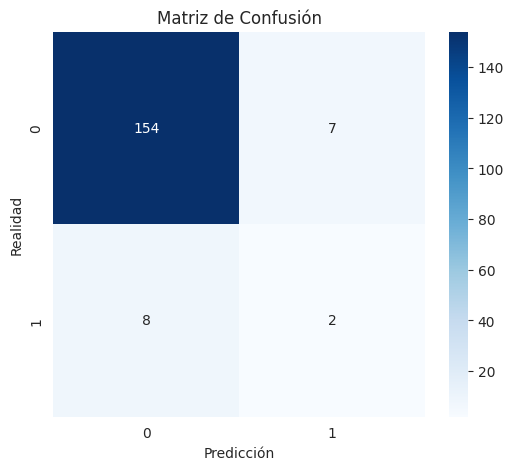

In [19]:
# Predicciones en el conjunto de TEST (que nunca fue clonado, es real)
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1] # Probabilidad de la clase 1 (Malo/Exitus)

# Métricas
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Accuracy Global: {acc:.4f}")
print(f"Balanced Accuracy (La métrica importante): {bal_acc:.4f}")

print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in nombres_clases]))

# Matriz de Confusión Visual
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=nombres_clases, yticklabels=nombres_clases)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.show()

CELDA 8: Guardado de Archivos (Para la App)

In [20]:
# Crear carpeta si no existe
os.makedirs(CARPETA_MODELO, exist_ok=True)

print(f"Guardando modelo en: {CARPETA_MODELO} ...")

# 1. Guardar el modelo entrenado
joblib.dump(modelo, os.path.join(CARPETA_MODELO, 'modelo_clasificacion.pkl'))

# 2. Guardar el scaler (necesario para preprocesar nuevos pacientes igual)
joblib.dump(scaler, os.path.join(CARPETA_MODELO, 'scaler.pkl'))

# 3. Guardar la lista de columnas (para asegurar el orden)
joblib.dump(columnas_finales, os.path.join(CARPETA_MODELO, 'columnas_modelo.pkl'))

# 4. Guardar los nombres de las clases (para el gráfico de la app)
joblib.dump(nombres_clases, os.path.join(CARPETA_MODELO, 'clases_target.pkl'))

print("🎉 ¡Todo guardado! Listo para usar en app.py")

Guardando modelo en: ../../models/gsitalta ...


🎉 ¡Todo guardado! Listo para usar en app.py
